In [1]:
# PACKAGES AND INCLUSIONS
using DiffEqFlux, OrdinaryDiffEq, Flux, Optim, Plots, LinearAlgebra
using Random
using ModelingToolkit
using MAT
using NNlib, ConcreteStructs, WeightInitializers, ChainRulesCore
using ComponentArrays
using Random
using ForwardDiff
using Flux: mae, update!, mean
using Flux
using Optimisers
pythonplot()

# DIRECTORY
dir         = @__DIR__
dir         = dir*"/"
cd(dir)
fname       = "Fisher_KPP_Source"
add_path    = "test/"
mkpath(dir*add_path*"figs")
mkpath(dir*add_path*"checkpoints")
mkpath(dir*add_path*"results")

# KAN PACKAGE LOAD
include("Lotka-Volterra/src/KolmogorovArnold.jl")
using .KolmogorovArnold

#Random
rng = Random.default_rng()
Random.seed!(rng, 0)

TaskLocalRNG()

Here we will use KAN-ODEs to try to learn a hidden term in the lotka voltera model 
$$ 
x' = x - h(x,y) \\ 
y' = h(x,y) - y
$$
where $h(x,y) = 0.5xy$. 

Our workflow will be as follows 
* Generate data for the model by simulating the true ode 
* define the KAN we will use for simulation
* Insert the known terms and the KAN into the ODE Problem
* define the loss by integrating the ODE problem and comparing it with the true data
* train the model

We'll first deal with the data generation. We'll simply use `ODEProblem` and `solve` from `DifferentialEquations`, then graph our solution to make sure everything is as it should be. 

┌ Warning: Using arrays or dicts to store parameters of different types can hurt performance.
│ Consider using tuples instead.
└ @ SciMLBase /home/lucas/.julia/packages/SciMLBase/tWwhl/src/performance_warnings.jl:33


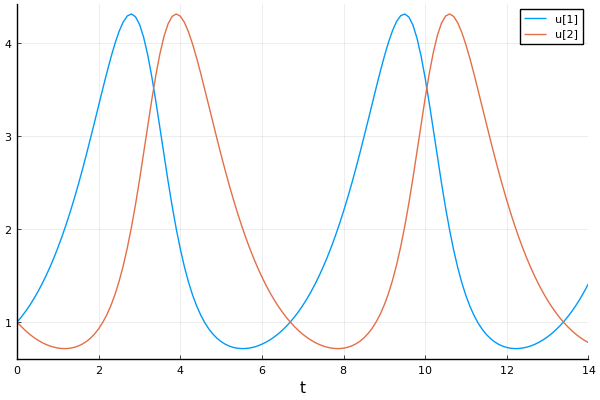

In [2]:
function lotka!(du,u,p,t) 
    du[1] = u[1] - 0.5*u[1]*u[2]
    du[2] = 0.5*u[1]*u[2] - u[2]
end

#data generation parameters
dt=0.1
tspan = (0.0, 14)
tspan_train=(0.0, 3.5)
u0 = [1, 1]
p_=[]
prob = ODEProblem(lotka!, u0,tspan,p_)

#generate training data, split into train/test
solution = solve(prob, Tsit5(), abstol = 1e-12, reltol = 1e-12, saveat = dt)
end_index=Int64(floor(length(solution.t)*tspan_train[2]/tspan[2]))
t = solution.t #full dataset
t_train=t[1:end_index] #training cut
X = Array(solution)
Xn = deepcopy(X) 
plot(solution)


Next we'll define the KAN. 

In [3]:
basis_func = rbf      # rbf, rswaf
normalizer = softsign # sigmoid(_fast), tanh(_fast), softsign

# Define KAN-ODEs
###layer_width and grid_size can be modified here to replicate the testing in section A2 of the manuscript

num_layers=2 #defined just to save into .mat for plotting
layer_width=10
grid_size=5
kan1 = Lux.Chain(
    KDense( 2, layer_width, grid_size; use_base_act = true, basis_func, normalizer),
    KDense(layer_width,  1, grid_size; use_base_act = true, basis_func, normalizer),
)
pM , stM  = Lux.setup(rng, kan1)
pM_data     = getdata(ComponentArray(pM))
pM_axis     = getaxes(ComponentArray(pM))
p = ComponentArray(pM_data, pM_axis) 
#p = (deepcopy(pM_data))./1e5 ;


ComponentVector{Float32}(layer_1 = (C = Float32[-0.48351604 0.44048923 … -0.19451302 0.28416148; -0.049033877 0.27051237 … -0.10067996 -0.28489357; … ; -0.09701933 0.12589002 … 0.19923212 -0.07273924; -0.5152452 0.18841727 … 0.46318942 -0.1626831], W = Float32[-0.522484 -0.69588506; -0.6805993 0.07831879; … ; 0.5799375 0.0803909; 0.39842856 -0.62709427]), layer_2 = (C = Float32[-0.32972547 -0.2085602 … 0.18974464 0.15347806], W = Float32[-0.14072634 -0.19323717 … -0.6127433 0.5011843]))

and construct the KAN-ODE. We'll also define the prediction function which will simulate the KAN-ODEs

In [4]:
# CONSTRUCT KAN-ODES
function kanode(u, p, t)
    kan1_(x) = kan1(x', ComponentArray(p,pM_axis), stM)[1]
    println("This me kan!")
    println(kan1)
    du[1] = u[1] - kan1_.(u)
    du[2] = kan1_.(u) - u[2]
end

# PREDICTION FUNCTION
function predict(p)
    prob = ODEProblem(kanode, u0, tspan_train,p, saveat=dt)
    sol = Array(solve(prob, Tsit5()));
end
#Prediction function over the test set.
function predict_test(p)
    prob = ODEProblem(kanode, u0, tspan,p, saveat=dt)
    sol = Array(solve(prob, Tsit5()));
end

predict_test (generic function with 1 method)

To define the loss function we'll use the MSE loss 
$$\mathcal{L}_1(\theta) = MSE(u^{\text{KAN}}(t, \theta), u^{\text{obs}}(t)) = \frac{1}{N}\sum_{i=1}^N \lVert u^{\text{KAN}}(t_i, \theta) - u^{\text{obs}}(t_i) \rVert^2 $$ 
We'll define two functions: one for the training loss and one for the test loss, the latter being used for model validation later on.

In [5]:
function loss_train(p)
    mean(abs2, Xn[:, 1:end_index].- predict(ComponentArray(p,pM_axis)))
end
function loss_test(p)
    mean(abs2, Xn .- predict_test(ComponentArray(p,pM_axis)))
end

loss_test (generic function with 1 method)

Now that we've defined our model, loss, and make prediction functions, we may make the training loop.

In [6]:
opt = Flux.Adam(5e-4)
using Zygote, ProgressBars, Printf
N_iter = 1000

for i in ProgressBar(1:N_iter)
    
    # GRADIENT COMPUTATION
    grad = Zygote.gradient(loss_train, p)[1]

    # UPDATE WITH ADAM OPTIMIZER
    update!(opt, p, grad)


    # CALLBACK
    loss_curr=deepcopy(loss_train(p))
    loss_curr_test=deepcopy(loss_test(p))
    set_description(i, string("Loss:", @sprintf("%.2f", loss_curr), "|",
                            "Train_Loss:", @sprintf("%.2f", loss_curr_test), "|"))
    # SAVE
    #callback(i)
end

0.0%

This me kan!


┣                                           ┫ 0/1.0k [00:02<-35:-46, -2s/it]


Lux.Chain{@NamedTuple{layer_1::KDense{true, typeof(softsign), Tuple{Float32, Float32}, Float32, typeof(rbf), typeof(swish), typeof(glorot_uniform), typeof(glorot_uniform)}, layer_2::KDense{true, typeof(softsign), Tuple{Float32, Float32}, Float32, typeof(rbf), typeof(swish), typeof(glorot_uniform), typeof(glorot_uniform)}}, Nothing}((layer_1 = KDense{true, typeof(softsign), Tuple{Float32, Float32}, Float32, typeof(rbf), typeof(swish), typeof(glorot_uniform), typeof(glorot_uniform)}(2, 10, 5, NNlib.softsign, (-1.0f0, 1.0f0), 0.5f0, Main.KolmogorovArnold.rbf, NNlib.swish, WeightInitializers.glorot_uniform, WeightInitializers.glorot_uniform), layer_2 = KDense{true, typeof(softsign), Tuple{Float32, Float32}, Float32, typeof(rbf), typeof(swish), typeof(glorot_uniform), typeof(glorot_uniform)}(10, 1, 5, NNlib.softsign, (-1.0f0, 1.0f0), 0.5f0, Main.KolmogorovArnold.rbf, NNlib.swish, WeightInitializers.glorot_uniform, WeightInitializers.glorot_uniform)), nothing)


┌ Warning: Potential performance improvement omitted. ZygoteVJP tried and failed in the automated AD choice algorithm. To show the stack trace, set SciMLSensitivity.STACKTRACE_WITH_VJPWARN[] = true. To turn off this printing, add `verbose = false` to the `solve` call.
└ @ SciMLSensitivity /home/lucas/.julia/packages/SciMLSensitivity/RQ8Av/src/concrete_solve.jl:122


┌ Warning: Potential performance improvement omitted. ReverseDiffVJP tried and failed in the automated AD choice algorithm. To show the stack trace, set SciMLSensitivity.STACKTRACE_WITH_VJPWARN[] = true. To turn off this printing, add `verbose = false` to the `solve` call.
└ @ SciMLSensitivity /home/lucas/.julia/packages/SciMLSensitivity/RQ8Av/src/concrete_solve.jl:140
┌ Warning: Potential performance improvement omitted. TrackerVJP tried and failed in the automated AD choice algorithm. To show the stack trace, set SciMLSensitivity.STACKTRACE_WITH_VJPWARN[] = true. To turn off this printing, add `verbose = false` to the `solve` call.
└ @ SciMLSensitivity /home/lucas/.julia/packages/SciMLSensitivity/RQ8Av/src/concrete_solve.jl:170



This me kan!


┌ Warning: Reverse-Mode AD VJP choices all failed. Falling back to numerical VJPs
└ @ SciMLSensitivity /home/lucas/.julia/packages/SciMLSensitivity/RQ8Av/src/concrete_solve.jl:180


Lux.Chain{@NamedTuple{layer_1::KDense{true, typeof(softsign), Tuple{Float32, Float32}, Float32, typeof(rbf), typeof(swish), typeof(glorot_uniform), typeof(glorot_uniform)}, layer_2::KDense{true, typeof(softsign), Tuple{Float32, Float32}, Float32, typeof(rbf), typeof(swish), typeof(glorot_uniform), typeof(glorot_uniform)}}, Nothing}((layer_1 = KDense{true, typeof(softsign), Tuple{Float32, Float32}, Float32, typeof(rbf), typeof(swish), typeof(glorot_uniform), typeof(glorot_uniform)}(2, 10, 5, NNlib.softsign, (-1.0f0, 1.0f0), 0.5f0, Main.KolmogorovArnold.rbf, NNlib.swish, WeightInitializers.glorot_uniform, WeightInitializers.glorot_uniform), layer_2 = KDense{true, typeof(softsign), Tuple{Float32, Float32}, Float32, typeof(rbf), typeof(swish), typeof(glorot_uniform), typeof(glorot_uniform)}(10, 1, 5, NNlib.softsign, (-1.0f0, 1.0f0), 0.5f0, Main.KolmogorovArnold.rbf, NNlib.swish, WeightInitializers.glorot_uniform, WeightInitializers.glorot_uniform)), nothing)


MethodError: MethodError: no method matching (::KDense{true, typeof(softsign), Tuple{Float32, Float32}, Float32, typeof(rbf), typeof(swish), typeof(glorot_uniform), typeof(glorot_uniform)})(::Float64, ::ComponentVector{Float32, SubArray{Float32, 1, Vector{Float32}, Tuple{UnitRange{Int64}}, true}, Tuple{Axis{(C = ViewAxis(1:100, ShapedAxis((10, 10))), W = ViewAxis(101:120, ShapedAxis((10, 2))))}}}, ::@NamedTuple{grid::Vector{Float32}})
The object of type `KDense{true, typeof(softsign), Tuple{Float32, Float32}, Float32, typeof(rbf), typeof(swish), typeof(glorot_uniform), typeof(glorot_uniform)}` exists, but no method is defined for this combination of argument types when trying to treat it as a callable object.

Closest candidates are:
  (::KDense{use_base_act})(!Matched::AbstractArray, ::Any, ::Any) where use_base_act
   @ Main.KolmogorovArnold ~/Projects/myKANs/KANODE/Lotka-Volterra/src/kdense.jl:134
